<h1>Esto es para Eitan</h1>

usar nbdime para hacer merges en el codigo con github

<h2>Fase 1: Business Understanding</h2>



El banco Monopoly lleva muchos años atendiendo a sus clientes en Chile y recientemente ha sido adquirido por un Banco con capitales extranjeros llamado “Dormammu”. Dormammu nos ha encargado hacer estudios sobre los clientes del banco Monopoly, para conocer su comportamiento y detectar patrones. Además, debemos analizar cómo será su estrategia para abordar estos nuevos clientes dado el uso que ellos hacen de sus productos financieros.

Nuestro objetivo es analizar su base de datos, limpiarla, seleccionar las variables que sirvan para alguna interpretación y entregar la mayor información posible a los dueños de este banco para que puedan conocer a los clientes, preparar una estrategia y abordar a este nuevo mercado.


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer
from sklearn.feature_selection import SelectKBest, f_classif

#%matplotlib inline

In [2]:
MONOPOLY_XLSX ='Base_clientes_Monopoly.xlsx'
MONOPOLY_CSV ='Base_clientes_Monopoly_otro.csv'

In [3]:
try:
    import common
    DATA = common.dataDirectory()
except ImportError:
    DATA = Path().resolve() / 'data'

In [4]:
df = pd.read_excel(MONOPOLY_XLSX)
df.head(10)

,Id,Subsegmento,Sexo,Region,Edad,Renta,Antiguedad,Internauta,Adicional,Dualidad,...,ColMx_T01,PagoNac_T01,PagoInt_T01,EeccNac_T01,EeccInt_T01,UsoL1_T01,UsoL2_T01,UsoLI_T01,IndRev_T01,target
0,1,160,M,13.0,43,NaN,130,1,1,0,...,0.0,33000,0.0,1099866.0,0.0,1099866.0,15080,0.0,R,0
1,2,160,H,13.0,46,143640.0,69,1,0,0,...,0.0,300000,0.0,214592.0,0.0,214592.0,83596,0.0,R,0
2,3,170,H,13.0,45,929106.0,24,1,1,0,...,0.0,216676,0.0,0.0,0.0,7400.0,0,0.0,T,0
3,4,151,H,13.0,46,172447.0,134,0,1,0,...,0.0,60000,0.0,272762.0,0.0,272762.0,10591,0.0,R,0
4,5,170,H,13.0,46,805250.0,116,0,1,1,...,0.0,272925,0.0,249562.0,0.0,75339.0,377782,0.0,R,0
5,6,170,H,13.0,47,707664.0,67,1,1,0,...,0.0,35800,0.0,35800.0,0.0,0.0,51197,0.0,R,0
6,7,811,H,13.0,48,1022833.0,21,1,0,1,...,0.0,9391,0.0,8818.0,0.0,8818.0,0,0.0,T,0
7,8,170,H,13.0,46,NaN,69,0,1,1,...,0.0,6000,0.0,283520.0,0.0,283520.0,0,0.0,R,0
8,9,170,H,13.0,49,1171066.0,33,0,0,0,...,0.0,60000,0.0,507629.0,0.0,507629.0,0,0.0,R,1
9,10,170,M,13.0,44,964387.0,23,1,1,0,...,0.0,92583,0.0,65487.0,0.0,65487.0,12084,0.0,R,0


<h2>Fase 2: Data Understanding</h2>


<h3>Variables elegidas</h3>


- Region ______________________________| Región de Residencia
- Renta _______________________________| Renta del cliente
- Edad ________________________________| Edad del cliente
- Sexo ________________________________| Sexo del cliente
- Adicional ___________________________| Indicador de Tenecia de TC adicionales
- Consumo _____________________________| Indicador de Crédito de Consumo
- Cuentas _____________________________| Número de cuentas que tiene el cliente
- Monoproducto ________________________| Indicador de si el cliente es solo poseedor de una TC
- TC __________________________________| Número de Tarjeta de crédito que tiene el cliente
- Internauta___________________________| Indicador de cliente Internauta que usa la web Monopoly
- Dualidad ____________________________| Indicador de Dualidad (Cliente es dual si tiene 2 o mas TC)
- CUPO_L1 _____________________________| Cupo de la tarjeta crédito para compras nacionales
- CUPO_MX _____________________________| Cupo de la tarjeta crédito para compras internacionales
- FlgActCOL_T12 _______________________| Indicador de actividad en avances en cuotas con tasa en el mes X en la TC
- Txs_T12 _____________________________| Número de transacciones realizados por el cliente en TC en el mes X
- FacCCOT_T12__________________________| Monto facturado en compras en cuotas con tasa por el cliente en TC en el mes X
- FacCI_T12 ___________________________| Monto facturado en compras internacionales por el cliente en TC en el mes X
- FacCN_T12 ___________________________| Monto facturado en compras nacionales por el cliente en TC en el mes X
- PagoInt_T12 _________________________| Monto de pagos de deuda internacional del cliente en el mes X
- PagoNac_T12 _________________________| Monto de pagos de deuda nacional del cliente en el mes X

<h3>Variable creada</h3>

- Paga_cuentas

Las variables region, edad y sexo fueron elegidas porque nos permiten segmentar a los clientes en base a características demográficas fundamentales.
Las variables renta, consumo, cuentas, monoproducto, TC, internauta y dualidad fueron elegidas porque nos permiten analizar el comportamiento financiero de los clientes.
Las variables CUPO_L1, CUPO_MX, FlgActCOL_TX, Txs_TX y FacCCOT_TX fueron elegidas porque nos permiten evaluar el riesgo de crédito y el uso de los productos de crédito

En resumen, la selección de estas variables se basa en la idea de que, para analizar bien el comportamiento de los clientes de tarjetas de crédito, es importante considerar tanto aspectos demográficos y socioeconómicos como el uso que le dan a la tarjeta. Al combinar estos datos, se puede tener una mejor visión del cliente y crear estrategias de marketing y abordar este mercado de mejor manera.

Para modelo de clasificacion queremos ver si el cliente paga o no paga sus deudas

In [12]:
df_monopoly = (df[['Region', 'Renta', 'Edad','Sexo', 'Adicional','Consumo', 'Cuentas', 'Monoproducto' , 'TC', 'Dualidad', 'CUPO_L1', 'CUPO_MX',
                    'FlgActCOL_T12', 'FlgActCOL_T11', 'FlgActCOL_T10', 'FlgActCOL_T09', 'FlgActCOL_T08', 'FlgActCOL_T07', 'FlgActCOL_T06', 'FlgActCOL_T05','FlgActCOL_T04' ,'FlgActCOL_T03', 'FlgActCOL_T02', 'FlgActCOL_T01',
                    'Txs_T12', 'Txs_T11', 'Txs_T10', 'Txs_T09', 'Txs_T08', 'Txs_T07', 'Txs_T06', 'Txs_T05', 'Txs_T04', 'Txs_T03', 'Txs_T02', 'Txs_T01',
                    'FacCCOT_T12', 'FacCCOT_T11', 'FacCCOT_T10', 'FacCCOT_T09', 'FacCCOT_T08', 'FacCCOT_T07', 'FacCCOT_T06', 'FacCCOT_T05', 'FacCCOT_T04', 'FacCCOT_T03', 'FacCCOT_T02', 'FacCCOT_T01',
                    'FacCI_T12', 'FacCI_T11', 'FacCI_T10', 'FacCI_T09', 'FacCI_T08', 'FacCI_T07', 'FacCI_T06', 'FacCI_T05', 'FacCI_T04', 'FacCI_T03', 'FacCI_T02', 'FacCI_T01',
                    'FacCN_T12', 'FacCN_T11', 'FacCN_T10', 'FacCN_T09', 'FacCN_T08', 'FacCN_T07', 'FacCN_T06', 'FacCN_T05', 'FacCN_T04', 'FacCN_T03', 'FacCN_T02', 'FacCN_T01',
                    'PagoInt_T12', 'PagoInt_T11', 'PagoInt_T10', 'PagoInt_T09', 'PagoInt_T08', 'PagoInt_T07', 'PagoInt_T06', 'PagoInt_T05', 'PagoInt_T04', 'PagoInt_T03', 'PagoInt_T02', 'PagoInt_T01',
                    'PagoNac_T12', 'PagoNac_T11', 'PagoNac_T10', 'PagoNac_T09', 'PagoNac_T08', 'PagoNac_T07', 'PagoNac_T06', 'PagoNac_T05', 'PagoNac_T04', 'PagoNac_T03', 'PagoNac_T02', 'PagoNac_T01']])
df_monopoly

,Region,Renta,Edad,Sexo,Adicional,Consumo,Cuentas,Monoproducto,TC,Dualidad,...,PagoNac_T10,PagoNac_T09,PagoNac_T08,PagoNac_T07,PagoNac_T06,PagoNac_T05,PagoNac_T04,PagoNac_T03,PagoNac_T02,PagoNac_T01
0,13.0,NaN,43,M,1,0,1,0,3,0,...,23000.0,24000.0,25000.0,26000.0,36000.0,50000.0,39000.0,41000.0,33000.0,33000
1,13.0,143640.0,46,H,0,0,1,0,1,0,...,194000.0,221000.0,180000.0,200000.0,100000.0,200000.0,200000.0,0.0,14000.0,300000
2,13.0,929106.0,45,H,1,0,1,0,2,0,...,14850.0,45890.0,0.0,60886.0,124289.0,69822.0,54138.0,0.0,25189.0,216676
3,13.0,172447.0,46,H,1,0,1,1,2,0,...,40000.0,60000.0,60000.0,45000.0,60000.0,50000.0,60000.0,60000.0,60000.0,60000
4,13.0,805250.0,46,H,1,0,2,0,3,1,...,301404.0,272969.0,435450.0,431776.0,386774.0,301860.0,246171.0,220811.0,143686.0,272925
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51119,13.0,364978.0,51,H,1,0,2,0,3,1,...,80000.0,85000.0,0.0,80000.0,155000.0,0.0,83000.0,0.0,50000.0,300000
51120,13.0,625376.0,51,H,0,0,1,0,1,0,...,35454.0,45711.0,10336.0,0.0,346717.0,159171.0,76775.0,169661.0,173162.0,166098
51121,13.0,806220.0,47,H,1,0,1,0,2,0,...,10000.0,110298.0,0.0,0.0,13092.0,13123.0,17283.0,26700.0,14700.0,18891
51122,13.0,NaN,47,M,0,0,1,0,1,0,...,0.0,0.0,47510.0,42031.0,46256.0,35158.0,18959.0,61173.0,25460.0,26528


In [6]:
df_monopoly.isna().sum()

Region            53
Renta          13365
Edad               0
Sexo               1
Adicional          0
               ...  
PagoNac_T05       25
PagoNac_T04       19
PagoNac_T03       10
PagoNac_T02       12
PagoNac_T01        0
Length: 72, dtype: int64

In [13]:
# Calculando la suma de pagos de los últimos 12 meses
df_monopoly['Total_Pagos_Deuda'] = df_monopoly[['PagoInt_T12', 'PagoInt_T11', 'PagoInt_T10', 'PagoInt_T09', 'PagoInt_T08', 'PagoInt_T07', 'PagoInt_T06', 'PagoInt_T05', 'PagoInt_T04', 'PagoInt_T03', 'PagoInt_T02', 'PagoInt_T01', 'PagoNac_T12', 'PagoNac_T11', 'PagoNac_T10', 'PagoNac_T09', 'PagoNac_T08', 'PagoNac_T07', 'PagoNac_T06', 'PagoNac_T05', 'PagoNac_T04', 'PagoNac_T03', 'PagoNac_T02', 'PagoNac_T01']].sum(axis=1)

# Definiendo un umbral de pago (por ejemplo, 90% de las facturas)
df_monopoly['Total_Facturas'] =  df_monopoly[['FacCI_T12', 'FacCI_T11', 'FacCI_T10', 'FacCI_T09', 'FacCI_T08', 'FacCI_T07', 'FacCI_T06', 'FacCI_T05', 'FacCI_T04', 'FacCI_T03', 'FacCI_T02', 'FacCI_T01',
                                              'FacCN_T12', 'FacCN_T11', 'FacCN_T10', 'FacCN_T09', 'FacCN_T08', 'FacCN_T07', 'FacCN_T06', 'FacCN_T05', 'FacCN_T04', 'FacCN_T03', 'FacCN_T02', 'FacCN_T01']].sum(axis=1)

df_monopoly['Paga_al_dia'] = df_monopoly['Total_Pagos_Deuda'] >= df_monopoly['Total_Facturas']
df_monopoly['Paga_al_dia'] = df_monopoly['Paga_al_dia'].astype(int)


#Otra manera de hacerlo como ayuda para futuro:

#df_monopoly['Paga_al_dia'] = 0
#df_monopoly.loc[df_monopoly['total_pago'] >= umbral, 'Paga_al_dia'] = 1

df_monopoly

C:\Users\Eitan\AppData\Local\Temp\ipykernel_1444\2088724061.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_monopoly['Total_Pagos_Deuda'] = df_monopoly[['PagoInt_T12', 'PagoInt_T11', 'PagoInt_T10', 'PagoInt_T09', 'PagoInt_T08', 'PagoInt_T07', 'PagoInt_T06', 'PagoInt_T05', 'PagoInt_T04', 'PagoInt_T03', 'PagoInt_T02', 'PagoInt_T01', 'PagoNac_T12', 'PagoNac_T11', 'PagoNac_T10', 'PagoNac_T09', 'PagoNac_T08', 'PagoNac_T07', 'PagoNac_T06', 'PagoNac_T05', 'PagoNac_T04', 'PagoNac_T03', 'PagoNac_T02', 'PagoNac_T01']].sum(axis=1)
C:\Users\Eitan\AppData\Local\Temp\ipykernel_1444\2088724061.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

,Region,Renta,Edad,Sexo,Adicional,Consumo,Cuentas,Monoproducto,TC,Dualidad,...,PagoNac_T07,PagoNac_T06,PagoNac_T05,PagoNac_T04,PagoNac_T03,PagoNac_T02,PagoNac_T01,Total_Pagos_Deuda,Total_Facturas,Paga_al_dia
0,13.0,NaN,43,M,1,0,1,0,3,0,...,26000.0,36000.0,50000.0,39000.0,41000.0,33000.0,33000,352000.0,3.862230e+05,0
1,13.0,143640.0,46,H,0,0,1,0,1,0,...,200000.0,100000.0,200000.0,200000.0,0.0,14000.0,300000,2009000.0,1.355021e+06,1
2,13.0,929106.0,45,H,1,0,1,0,2,0,...,60886.0,124289.0,69822.0,54138.0,0.0,25189.0,216676,819909.0,1.787789e+06,0
3,13.0,172447.0,46,H,1,0,1,1,2,0,...,45000.0,60000.0,50000.0,60000.0,60000.0,60000.0,60000,685000.0,4.142860e+05,1
4,13.0,805250.0,46,H,1,0,2,0,3,1,...,431776.0,386774.0,301860.0,246171.0,220811.0,143686.0,272925,3495806.0,3.527268e+06,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51119,13.0,364978.0,51,H,1,0,2,0,3,1,...,80000.0,155000.0,0.0,83000.0,0.0,50000.0,300000,958000.0,8.268950e+05,1
51120,13.0,625376.0,51,H,0,0,1,0,1,0,...,0.0,346717.0,159171.0,76775.0,169661.0,173162.0,166098,1236737.0,1.384888e+06,0
51121,13.0,806220.0,47,H,1,0,1,0,2,0,...,0.0,13092.0,13123.0,17283.0,26700.0,14700.0,18891,304087.0,1.691690e+05,1
51122,13.0,NaN,47,M,0,0,1,0,1,0,...,42031.0,46256.0,35158.0,18959.0,61173.0,25460.0,26528,303075.0,4.027820e+05,0


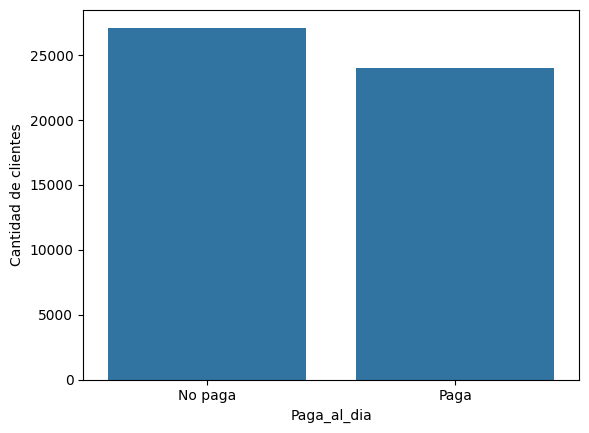

In [18]:
sns.countplot(x='Paga_al_dia', data=df_monopoly)
plt.xticks([0, 1], ['No paga', 'Paga'])
plt.ylabel('Cantidad de clientes')
plt.show()

<h4>Limpiamos las variables que queremos utilizar:</h4>

<h5>Dividimos en tipo de variables:</h5>

In [ ]:
var_continuas = (df_monopoly[['Renta', 'CUPO_L1', 'CUPO_MX', 'FlgActCOL_T12', 'FlgActCOL_T11', 'FlgActCOL_T10', 'FlgActCOL_T09', 'FlgActCOL_T08', 'FlgActCOL_T07', 'FlgActCOL_T06','FlgActCOL_T05','FlgActCOL_T04' ,'FlgActCOL_T03', 'FlgActCOL_T02', 'FlgActCOL_T01', 'Txs_T12', 'Txs_T11', 'Txs_T10', 'Txs_T09', 'Txs_T08', 'Txs_T07', 'Txs_T06', 'Txs_T05', 'Txs_T04', 'Txs_T03', 'Txs_T02', 'Txs_T01', 'FacCCOT_T12', 'FacCCOT_T11', 'FacCCOT_T10', 'FacCCOT_T09', 'FacCCOT_T08', 'FacCCOT_T07', 'FacCCOT_T06', 'FacCCOT_T05', 'FacCCOT_T04', 'FacCCOT_T03', 'FacCCOT_T02', 'FacCCOT_T01', 'PagoInt_T12', 'PagoInt_T11', 'PagoInt_T10', 'PagoInt_T09', 'PagoInt_T08', 'PagoInt_T07', 'PagoInt_T06', 'PagoInt_T05', 'PagoInt_T04', 'PagoInt_T03', 'PagoInt_T02', 'PagoInt_T01', 'PagoNac_T12', 'PagoNac_T11', 'PagoNac_T10', 'PagoNac_T09', 'PagoNac_T08', 'PagoNac_T07', 'PagoNac_T06', 'PagoNac_T05', 'PagoNac_T04', 'PagoNac_T03', 'PagoNac_T02', 'PagoNac_T01' ]])

var_discretas = (df_monopoly[['Edad', 'Cuentas', 'TC']])

var_nominales = (df_monopoly[['Sexo', 'Adicional', 'Consumo', 'Monoproducto', 'Dualidad', 'Paga_al_dia']])

var_ordinales = (df_monopoly[['Region']])

<h2>Fase 3: Data Preparation</h2>

In [20]:
df_clean = df_monopoly.copy()
var_norm = ['Renta', 'CUPO_L1', 'CUPO_MX', 'FlgActCOL_T12', 'FlgActCOL_T11', 'FlgActCOL_T10', 'FlgActCOL_T09', 'FlgActCOL_T08', 'FlgActCOL_T07', 'FlgActCOL_T06','FlgActCOL_T05','FlgActCOL_T04' ,'FlgActCOL_T03', 'FlgActCOL_T02', 'FlgActCOL_T01', 'Txs_T12', 'Txs_T11', 'Txs_T10', 'Txs_T09', 'Txs_T08', 'Txs_T07', 'Txs_T06', 'Txs_T05', 'Txs_T04', 'Txs_T03', 'Txs_T02', 'Txs_T01', 'FacCCOT_T12', 'FacCCOT_T11', 'FacCCOT_T10', 'FacCCOT_T09', 'FacCCOT_T08', 'FacCCOT_T07', 'FacCCOT_T06', 'FacCCOT_T05', 'FacCCOT_T04', 'FacCCOT_T03', 'FacCCOT_T02', 'FacCCOT_T01', 'PagoInt_T12', 'PagoInt_T11', 'PagoInt_T10', 'PagoInt_T09', 'PagoInt_T08', 'PagoInt_T07', 'PagoInt_T06', 'PagoInt_T05', 'PagoInt_T04', 'PagoInt_T03', 'PagoInt_T02', 'PagoInt_T01', 'PagoNac_T12', 'PagoNac_T11', 'PagoNac_T10', 'PagoNac_T09', 'PagoNac_T08', 'PagoNac_T07', 'PagoNac_T06', 'PagoNac_T05', 'PagoNac_T04', 'PagoNac_T03', 'PagoNac_T02', 'PagoNac_T01'] 
var_estand = ['Renta', 'CUPO_L1', 'CUPO_MX', 'FlgActCOL_T12', 'FlgActCOL_T11', 'FlgActCOL_T10', 'FlgActCOL_T09', 'FlgActCOL_T08', 'FlgActCOL_T07', 'FlgActCOL_T06','FlgActCOL_T05','FlgActCOL_T04' ,'FlgActCOL_T03', 'FlgActCOL_T02', 'FlgActCOL_T01', 'Txs_T12', 'Txs_T11', 'Txs_T10', 'Txs_T09', 'Txs_T08', 'Txs_T07', 'Txs_T06', 'Txs_T05', 'Txs_T04', 'Txs_T03', 'Txs_T02', 'Txs_T01', 'FacCCOT_T12', 'FacCCOT_T11', 'FacCCOT_T10', 'FacCCOT_T09', 'FacCCOT_T08', 'FacCCOT_T07', 'FacCCOT_T06', 'FacCCOT_T05', 'FacCCOT_T04', 'FacCCOT_T03', 'FacCCOT_T02', 'FacCCOT_T01', 'PagoInt_T12', 'PagoInt_T11', 'PagoInt_T10', 'PagoInt_T09', 'PagoInt_T08', 'PagoInt_T07', 'PagoInt_T06', 'PagoInt_T05', 'PagoInt_T04', 'PagoInt_T03', 'PagoInt_T02', 'PagoInt_T01', 'PagoNac_T12', 'PagoNac_T11', 'PagoNac_T10', 'PagoNac_T09', 'PagoNac_T08', 'PagoNac_T07', 'PagoNac_T06', 'PagoNac_T05', 'PagoNac_T04', 'PagoNac_T03', 'PagoNac_T02', 'PagoNac_T01']

<h4>Normalizamos y Estandarizamos las variables</h4>

In [1]:
#Aqui limpiamos las variables:
for i in df_monopoly.columns[:-2]:
    mean = df_monopoly[i].mean()
    std = df_monopoly[i].std()
    mini = df_monopoly[i].min()
    maxi = df_monopoly[i].max()

    if i not in ['Edad', 'Region', 'Cuentas', 'TC']:
        df_monopoly[i] = df_monopoly[i].apply(lambda x: (x - mean) / std)

    else:
        df_monopoly[i] = df_monopoly[i].apply(lambda x: (x - mini) / (maxi - mini))